In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "recommender-model-1"
REMARK = ""
BATCH_SIZE = 128
LEARNING_RATE = 1e-5
EPOCH = 45
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanAbsoluteError()

# Skip this: Avg Rating ver

## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [2]:
DATA_DIR = os.path.join("../data/synt_data_with_average_rating/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [3]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,price_category,avg_rating
0,1723,HIGH,HIGH,HIGH,"Drama,Romance,School,Supernatural",HIGH,5.000000
1,82,HIGH,HIGH,HIGH,"Action,Adventure,Drama,Fantasy,Shounen",HIGH,4.940299
2,296,HIGH,HIGH,HIGH,"Action,Comedy,Sci-Fi,Shounen",HIGH,4.934871
3,127,HIGH,HIGH,HIGH,Sci-Fi,HIGH,4.891452
4,137,HIGH,HIGH,HIGH,"Action,Comedy,Sci-Fi,Shounen",HIGH,4.886024


In [4]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6238 entries, 0 to 6237
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              6238 non-null   int64  
 1   insta_follower  6238 non-null   object 
 2   tiktok          6238 non-null   object 
 3   youtube         6238 non-null   object 
 4   categories      6238 non-null   object 
 5   price_category  6238 non-null   object 
 6   avg_rating      6238 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 341.3+ KB


In [5]:
df_influencer.describe()

,id,avg_rating
count,6238.000000,6238.000000
mean,3476.966656,3.699491
std,2136.753019,0.422217
min,1.000000,1.000000
25%,1610.250000,3.447761
50%,3308.500000,3.724559
75%,5285.750000,3.974220
max,7387.000000,5.000000


In [6]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.82
1,1,3,3,0.56
2,1,5,5,0.93
3,1,6,5,1.00
4,1,7,4,0.74


In [7]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409712 entries, 0 to 409711
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            409712 non-null  int64  
 1   inf_id            409712 non-null  int64  
 2   star_rating       409712 non-null  int64  
 3   sentiment_rating  409712 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.5 MB


In [8]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,409712.000000,409712.000000,409712.000000,409712.000000
mean,2446.166034,1079.041366,4.141360,0.777423
std,1438.816431,1149.462867,0.789167,0.161781
min,1.000000,1.000000,1.000000,0.000000
25%,1215.000000,261.000000,4.000000,0.680000
50%,2460.000000,640.000000,4.000000,0.790000
75%,3699.000000,1538.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [9]:
df_influencer.isnull().sum()

id                0
insta_follower    0
tiktok            0
youtube           0
categories        0
price_category    0
avg_rating        0
dtype: int64

In [10]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [11]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [12]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [13]:
# follower_scaler = MinMaxScaler()
rating_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm['avg_rating'] = rating_scaler.fit_transform(df_inf_norm[['avg_rating']])
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

df_inf_norm = one_hot(df_inf_norm, 'youtube') 
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1723,1.000000,1,0,0,0,0,0,1,0,...,1,1,0,0,1,0,0,1,0,0
1,82,0.985075,1,0,0,1,1,0,1,1,...,0,1,0,0,1,0,0,1,0,0
2,296,0.983718,1,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,127,0.972863,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,137,0.971506,1,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


Combine star and sentiment rating

In [14]:
STAR_WEIGHT = 0.6
SENTIMENT_WEIGHT = 0.4

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,1,1,4,0.82,0.808
1,1,3,3,0.56,0.584
2,1,5,5,0.93,0.972
3,1,6,5,1.00,1.000
4,1,7,4,0.74,0.776
...,...,...,...,...,...
409707,4999,49,5,0.90,0.960
409708,4999,670,5,0.82,0.928
409709,4999,62,5,0.80,0.920
409710,4999,770,5,0.98,0.992


In [15]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2711,2711,2711,2711
2,9155,9155,9155,9155
3,58985,58985,58985,58985
4,195516,195516,195516,195516
5,143345,143345,143345,143345


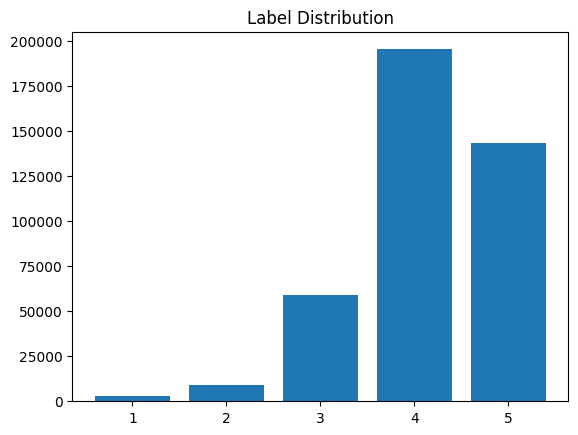

In [16]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [17]:
df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features.head()

,own_id,inf_id,combined_rating,id,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,1,0.808,1,0.725916,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0
1,1,3,0.584,3,0.658073,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,5,0.972,5,0.751696,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,6,1.000,6,0.910448,1,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
4,1,7,0.776,7,0.854817,1,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0


In [18]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm = df_own_norm.drop(['avg_rating'], axis=1)
df_own_norm.head()

,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,0.545000,0.000000,0.295500,0.309000,0.000000,0.374500,0.541500,0.216000,0.434500,...,0.440500,0.840500,0.0,0.000000,0.840500,0.0,0.000000,0.840500,0.0,0.000000
1,2,0.462334,0.032486,0.382869,0.376729,0.185119,0.417301,0.200170,0.251623,0.252754,...,0.246675,0.782018,0.0,0.095672,0.809617,0.0,0.068073,0.580511,0.0,0.297179
2,3,0.585529,0.000000,0.297176,0.262353,0.220471,0.530471,0.246471,0.239765,0.254706,...,0.190706,0.831176,0.0,0.051529,0.882706,0.0,0.000000,0.610000,0.0,0.272706
3,4,0.709951,0.000000,0.114829,0.626634,0.264683,0.389951,0.135805,0.326927,0.306244,...,0.383220,0.805659,0.0,0.019122,0.805659,0.0,0.019122,0.805659,0.0,0.019122
4,5,0.617409,0.000000,0.198000,0.285409,0.141818,0.434591,0.219909,0.177000,0.224273,...,0.272682,0.806682,0.0,0.008727,0.806682,0.0,0.008727,0.736500,0.0,0.078909


##### Process feature and label

Influencer features

In [19]:
# Remove ID and labels
df_inf_features = df_inf_features.drop(["own_id", "inf_id", "id"], axis=1)

df_inf_features.head()

,combined_rating,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.808,0.725916,0,0,1,1,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0.584,0.658073,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,0.972,0.751696,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
3,1.000,0.910448,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
4,0.776,0.854817,1,0,0,0,0,1,1,0,...,1,1,0,0,1,0,0,1,0,0


In [20]:
df_inf_features_pos = df_inf_features[df_inf_features["combined_rating"] > 0.6].drop(["combined_rating"], axis=1)
df_inf_features_neg = df_inf_features[df_inf_features["combined_rating"] <= 0.6].drop(["combined_rating"], axis=1)

df_inf_features_pos

,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.725916,0,0,1,1,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,0
2,0.751696,0,0,1,0,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.910448,1,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
4,0.854817,1,0,0,0,0,1,1,0,1,...,1,1,0,0,1,0,0,1,0,0
5,0.957938,1,0,0,0,0,0,1,1,1,...,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409707,0.926730,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
409708,0.848033,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
409709,0.947083,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
409710,0.762551,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [21]:
INFLUENCER_FEATURE_COUNT = len(df_inf_features.drop("combined_rating", axis=1).columns)

Owner features

In [22]:
# Join history and owner data by own_id
df_own_features = pd.merge(df_history, df_own_norm, left_on='own_id', right_on='id', how='left')

df_own_features.head()

,own_id,inf_id,combined_rating,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,1,0.808,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
1,1,3,0.584,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
2,1,5,0.972,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
3,1,6,1.000,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
4,1,7,0.776,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0


In [23]:
# Remove ID and labels
df_own_features = df_own_features.drop(["own_id", "inf_id", "id"], axis=1)

df_own_features.head()

,combined_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.808,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
1,0.584,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
2,0.972,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
3,1.000,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
4,0.776,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0


In [24]:
df_own_features_pos = df_own_features[df_own_features["combined_rating"] > 0.6].drop(["combined_rating"], axis=1)
df_own_features_neg = df_own_features[df_own_features["combined_rating"] <= 0.6].drop(["combined_rating"], axis=1)

df_own_features_pos

,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
2,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
3,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
4,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
5,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409707,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,...,0.0000,0.9500,0.0,0.0,0.9500,0.0,0.0,0.9500,0.0,0.0
409708,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,...,0.0000,0.9500,0.0,0.0,0.9500,0.0,0.0,0.9500,0.0,0.0
409709,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,...,0.0000,0.9500,0.0,0.0,0.9500,0.0,0.0,0.9500,0.0,0.0
409710,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,...,0.0000,0.9500,0.0,0.0,0.9500,0.0,0.0,0.9500,0.0,0.0


In [25]:
OWNER_FEATURE_COUNT = len(df_own_features.drop("combined_rating", axis=1).columns)

Labels

In [26]:
# Get labels from history data
df_labels = df_history["combined_rating"]
df_labels.head()

0    0.808
1    0.584
2    0.972
3    1.000
4    0.776
Name: combined_rating, dtype: float64

In [27]:
df_labels_pos = df_labels[df_labels > 0.6]
df_labels_neg = df_labels[df_labels <= 0.6]

df_labels_pos

0         0.808
2         0.972
3         1.000
4         0.776
5         0.920
          ...  
409707    0.960
409708    0.928
409709    0.920
409710    0.992
409711    1.000
Name: combined_rating, Length: 358181, dtype: float64

##### Generate train, validation, and test dataset

In [28]:
SHUFFLE_BUFFER = 1000

dataset = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features, "own_feature": df_own_features}, df_labels))
# dataset = dataset.shuffle(SHUFFLE_BUFFER) 

dataset.element_spec

({'inf_feature': TensorSpec(shape=(24,), dtype=tf.float64, name=None),
  'own_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None)},
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [29]:
# Generate training, validation, and testing data
DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE * 0.9)
VAL_SIZE = int(DATASET_SIZE * 0.05)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 368740 data
Validation dataset has 20485 data
Testing dataset has 20487 data


In [30]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE).repeat(REPEAT)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

##### Generate train, validation, and test dataset (positive and negative)

In [31]:
SHUFFLE_BUFFER = 1000

dataset_pos = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_pos, "own_feature": df_own_features_pos}, df_labels_pos))
# dataset_pos = dataset_pos.shuffle(SHUFFLE_BUFFER) 
dataset_neg = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_neg, "own_feature": df_own_features_neg}, df_labels_neg))
# dataset_neg = dataset_neg.shuffle(SHUFFLE_BUFFER) 

print("Positive data:", dataset_pos.element_spec)
print("Count positive data:", dataset_pos.cardinality().numpy())

print("\nNegative data:", dataset_neg.element_spec)
print("Count negative data:", dataset_neg.cardinality().numpy())

Positive data: ({'inf_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None), 'own_feature': TensorSpec(shape=(22,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))
Count positive data: 358181

Negative data: ({'inf_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None), 'own_feature': TensorSpec(shape=(22,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))
Count negative data: 51531


In [32]:
# Generate training, validation, and testing data
POSITIVE_SIZE = dataset_pos.cardinality().numpy()
TRAIN_POS_SIZE = int(POSITIVE_SIZE * 0.9)
VAL_POS_SIZE = int(POSITIVE_SIZE * 0.05)
TEST_POS_SIZE = POSITIVE_SIZE - TRAIN_POS_SIZE - VAL_POS_SIZE

train_dataset_pos = dataset_pos.take(TRAIN_POS_SIZE)
val_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE).take(VAL_POS_SIZE)
test_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE + VAL_POS_SIZE).take(TEST_POS_SIZE)

print(f"Positive training dataset has {train_dataset_pos.cardinality().numpy()} data")
print(f"Positive validation dataset has {val_dataset_pos.cardinality().numpy()} data")
print(f"Positive testing dataset has {test_dataset_pos.cardinality().numpy()} data")

Positive training dataset has 322362 data
Positive validation dataset has 17909 data
Positive testing dataset has 17910 data


In [33]:
# Generate training, validation, and testing data
NEGATIVE_SIZE = dataset_neg.cardinality().numpy()
TRAIN_NEG_SIZE = int(NEGATIVE_SIZE * 0.5)
VAL_NEG_SIZE = int(NEGATIVE_SIZE * 0.25)
TEST_NEG_SIZE = NEGATIVE_SIZE - TRAIN_NEG_SIZE - VAL_NEG_SIZE

train_dataset_neg = dataset_neg.take(TRAIN_NEG_SIZE)
val_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE).take(VAL_NEG_SIZE)
test_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE + VAL_NEG_SIZE).take(TEST_NEG_SIZE)

print(f"Negative training dataset has {train_dataset_neg.cardinality().numpy()} data")
print(f"Negative validation dataset has {val_dataset_neg.cardinality().numpy()} data")
print(f"Negative testing dataset has {test_dataset_neg.cardinality().numpy()} data")

Negative training dataset has 25765 data
Negative validation dataset has 12882 data
Negative testing dataset has 12884 data


In [34]:
train_dataset = train_dataset_pos.concatenate(train_dataset_neg)
val_dataset = val_dataset_pos.concatenate(val_dataset_neg)
test_dataset = test_dataset_pos.concatenate(test_dataset_neg)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 348127 data
Validation dataset has 30791 data
Testing dataset has 30794 data


In [35]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Error Analysis

In [36]:
import os

MODEL = "recommender-avgrating-moredropout"

In [37]:
with open(os.path.join("model/summary/", MODEL + ".txt")) as f:
    print("".join(f.readlines()))

Influencer Model:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               12288     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
Total params: 90,368
Trainable param

In [38]:
import tensorflow as tf

print(tf.__version__)

export_path = f"./model/savedmodel/{MODEL}/"
model = tf.saved_model.load(export_path)
infer = model.signatures["serving_default"]
print(infer.inputs, "\n\n", infer.outputs)

2.12.0
[<tf.Tensor 'inf_feature:0' shape=(None, 23) dtype=float32>, <tf.Tensor 'own_feature:0' shape=(None, 22) dtype=float32>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=resource>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=resource>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=resource>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=resource>, <tf.Tensor 'unknown_7:0' shape=() dtype=resource>, <tf.Tensor 'unknown_8:0' shape=() dtype=resource>, <tf.Tensor 'unknown_9:0' shape=() dtype=resource>, <tf.Tensor 'unknown_10:0' shape=() dtype=resource>, <tf.Tensor 'unknown_11:0' shape=() dtype=resource>, <tf.Tensor 'unknown_12:0' shape=() dtype=resource>, <tf.Tensor 'unknown_13:0' shape=() dtype=resource>, <tf.Tensor 'unknown_14:0' shape=() dtype=resource>] 

 [<tf.Tensor 'Identity:0' shape=(None, 1) dtype=flo

Helpers

In [39]:
def convert_tensor(array):
    return tf.expand_dims(tf.convert_to_tensor(array, tf.float32), 0)

def convert_dataset_to_numpy(dataset):
    inputs = []
    labels = np.array([])
    for batch in dataset:
        # batch_input = []
        # for data in batch[0]['inf_feature']:
        #     batch_input.append({'inputs_0': data})
        
        # for i, data in enumerate(batch[0]['own_feature']):
        #     batch_input[i]['inputs_1'] = data

        # inputs.append(batch_input)
        inf_feature = batch[0]['inf_feature'].numpy()
        own_feature = batch[0]['own_feature'].numpy()

        
        # print(inf_feature, own_feature)
        inputs += [{"inf_feature": convert_tensor(a_val), "own_feature": convert_tensor(b_val)} for a_val, b_val in zip(inf_feature, own_feature)]

        labels = np.concatenate([labels, batch[1].numpy()])

    return inputs, labels

def get_comparation_from_dataset(dataset, infer):
    inputs, labels = convert_dataset_to_numpy(dataset)
    
    predict = []
    for data in inputs:
        predict.append(infer(**data))

    predict = list(pred['dot_2'].numpy()[0] for pred in predict)

    compare = pd.concat([pd.DataFrame(predict, columns=["predicted"]), 
                     pd.DataFrame(labels, columns=["real"])], axis=1)

    compare["error"] = abs(compare["predicted"] - compare["real"])

    return compare

def get_rank_quality(real_rank, predicted_rank):
    from scipy.stats import kendalltau

    corr_score = []
    count = []
    for id, rank in real_rank.iteritems():
        # print(list(rank)[:len(predicted_rank[id])], list(predicted_rank[id]))
        correlation, _ = kendalltau(list(rank), list(predicted_rank[id]))
        corr_score.append(correlation)
        count.append(len(list(rank)))

    df_corr = pd.concat([real_rank, predicted_rank, pd.Series(corr_score, index=real_rank.index), pd.Series(count, index=real_rank.index)], axis=1)
    return df_corr

def ap_at_k(real_rank, predicted_rank, k):
    ap_score = []
    for id, rank in real_rank.iteritems():
        pred = predicted_rank[id]
        relevancy = [int(el in rank[:k]) for el in pred[:k]]
        ap_score.append(sum(elem / (index + 1) for index, elem in enumerate(relevancy)) / len(relevancy))
    
    return np.array(ap_score)

In [40]:
# compare_train = get_comparation_from_dataset(train_dataset, infer)
# compare_val = get_comparation_from_dataset(val_dataset, infer)
compare_test = get_comparation_from_dataset(dataset_pos.batch(BATCH_SIZE).concatenate(dataset_neg.batch(BATCH_SIZE)), infer)

In [41]:
compare_test

,predicted,real,error
0,0.734864,0.808,0.073136
1,0.759488,0.972,0.212512
2,0.844292,1.000,0.155708
3,0.840925,0.776,0.064925
4,0.843382,0.920,0.076618
...,...,...,...
409707,0.686847,0.584,0.102847
409708,0.677900,0.572,0.105900
409709,0.681726,0.528,0.153726
409710,0.670619,0.600,0.070619


In [42]:
compare_test['error'].mean()

0.1358440694428421

In [43]:
# Get owner and influencer data
pos_owner_inf = df_history.iloc[df_inf_features_pos.index]
neg_owner_inf = df_history.iloc[df_inf_features_neg.index]
combined_owner_inf = pd.concat([pos_owner_inf, neg_owner_inf], axis=0).drop('combined_rating', axis=1)
combined_owner_inf

,own_id,inf_id
0,1,1
2,1,5
3,1,6
4,1,7
5,1,8
...,...,...
409688,4998,643
409691,4998,1894
409696,4998,1217
409699,4998,2220


In [44]:
test = pd.concat([combined_owner_inf.reset_index(), compare_test.reset_index()], axis=1)
test = test.drop('index', axis=1)
test

,own_id,inf_id,predicted,real,error
0,1,1,0.734864,0.808,0.073136
1,1,5,0.759488,0.972,0.212512
2,1,6,0.844292,1.000,0.155708
3,1,7,0.840925,0.776,0.064925
4,1,8,0.843382,0.920,0.076618
...,...,...,...,...,...
409707,4998,643,0.686847,0.584,0.102847
409708,4998,1894,0.677900,0.572,0.105900
409709,4998,1217,0.681726,0.528,0.153726
409710,4998,2220,0.670619,0.600,0.070619


In [45]:
real_rank = test.groupby('own_id').apply(lambda x: x.sort_values(by='real', ascending=False)['inf_id'].tolist())
predicted_rank = test.groupby('own_id').apply(lambda x: x.sort_values(by='predicted', ascending=False)['inf_id'].tolist())

In [52]:
ap_at_k(real_rank, predicted_rank, 5).mean()

C:\Users\MAS GAMING\AppData\Local\Temp\ipykernel_18600\2863270594.py:59: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, rank in real_rank.iteritems():


0.20238637703719425

In [ ]:
test = pd.merge(test, df_influencer, how='left', left_on ='inf_id', right_on='id')
test = pd.merge(test, df_own_norm, how='left', left_on='own_id', right_on='id')

In [ ]:
test.to_csv("test.csv")
df_corr.to_csv("correlations.csv")

In [ ]:
# compare_val['error'].mean()

In [ ]:
# compare_test['error'].mean()